In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.keras._impl.keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import operator
from functools import reduce
import datetime as dt
import matplotlib.dates as mdates

In [2]:
dataset = pd.read_csv('/home/yaoling/Desktop/hangyan/income_PCA.csv', index_col=['stat_date'], parse_dates=['stat_date'])
dataset.head(3)

,Unnamed: 0,origin_total,total,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,...,Comp.9,Comp.10,Comp.11,Comp.12,Comp.13,Comp.14,Comp.15,Comp.16,Comp.17,Comp.18
stat_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,1.054359e+09,1.060150e+09,-3.722967,3.995390,-1.427039,-0.342712,0.250247,1.122027,0.187155,...,-0.013872,2.537875,-0.090666,-0.115397,-0.085228,0.078117,0.238693,0.359661,-0.213082,-0.017273
2016-01-02,2,1.066313e+09,1.070989e+09,-3.977367,3.852914,-1.388795,-0.385318,0.282414,1.105422,0.255038,...,-0.039693,2.252362,0.018632,-0.507548,-0.359579,0.164461,0.175537,0.172459,-0.205090,-0.049985
2016-01-03,3,1.092257e+09,1.091527e+09,-3.834691,2.950487,-2.036668,-0.270303,0.362256,1.271677,-0.045781,...,0.242025,1.494543,0.392993,-0.250873,0.524982,0.683681,0.021026,0.251070,-0.336074,0.098757


In [3]:
total= dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(7)
train_dataset= dataset.drop((missing_data[missing_data['Total'] > 400]).index,1)


In [4]:
train_dataset = dataset.iloc[:,2:3]


No handles with labels found to put in legend.


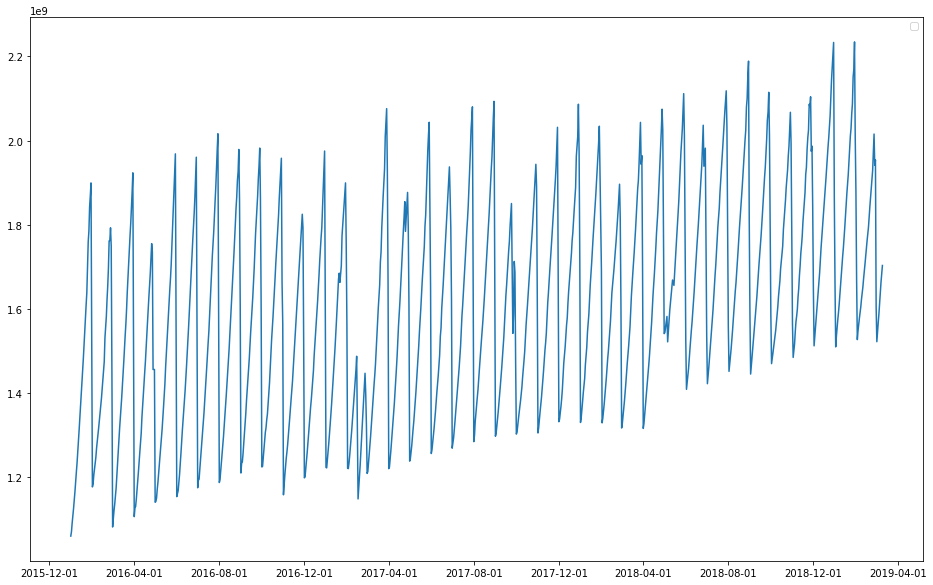

In [5]:
plt.figure(figsize=(16,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(train_dataset)
plt.legend()
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(train_dataset)

In [7]:
def create_train_dataset(dataset, steps):
    X_train, Y_train = [], []
    for i in range(steps, len(dataset)):
        X_train.append(training_set_scaled[i-steps])
        Y_train.append(training_set_scaled[i, 0])
    return np.array(X_train), np.array(Y_train)


In [8]:
split_rate = 0.7
k = int(len(training_set_scaled)*split_rate)
def create_test_dataset(dataset, steps):
    X_test, Y_test = [], []
    for i in range(steps, len(dataset)):
        X_test.append(training_set_scaled[i-steps+k])
        Y_test.append(training_set_scaled[i+k, 0])
    return np.array(X_test), np.array(Y_test)

In [9]:
train_size = int(len(train_dataset) * split_rate)
test_size = len(train_dataset) - train_size
train, test = train_dataset[0:train_size], train_dataset[train_size:len(train_dataset)]

In [10]:
steps = 3
X_train, Y_train = create_train_dataset(train, steps)
X_test, Y_test = create_test_dataset(test, steps)


In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
regressor = tf.keras.models.Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='adam')

regressor.fit(X_train, Y_train, epochs=5, batch_size = 1)

Epoch 1/5
812/812 [==============================] - 5s 6ms/step - loss: 0.0382
Epoch 2/5
812/812 [==============================] - 3s 4ms/step - loss: 0.0267
Epoch 3/5
812/812 [==============================] - 3s 4ms/step - loss: 0.0269
Epoch 4/5
812/812 [==============================] - 3s 4ms/step - loss: 0.0271
Epoch 5/5
812/812 [==============================] - 3s 4ms/step - loss: 0.0259


In [13]:
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)
trainPredict.shape, testPredict.shape

((812, 1), (347, 1))

In [14]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_test])

In [15]:
import math
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 190759307.91 RMSE
Test Score: 230099360.59 RMSE


In [16]:
train_dataset['predict'] = 0
type(trainPredict), trainPredict.shape

(numpy.ndarray, (812, 1))

In [17]:
trainPredict = trainPredict.flatten()
testPredict = testPredict.flatten()

In [18]:
train_dataset['predict'][3:815] = trainPredict
train_dataset['predict'][815:-3] = testPredict


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


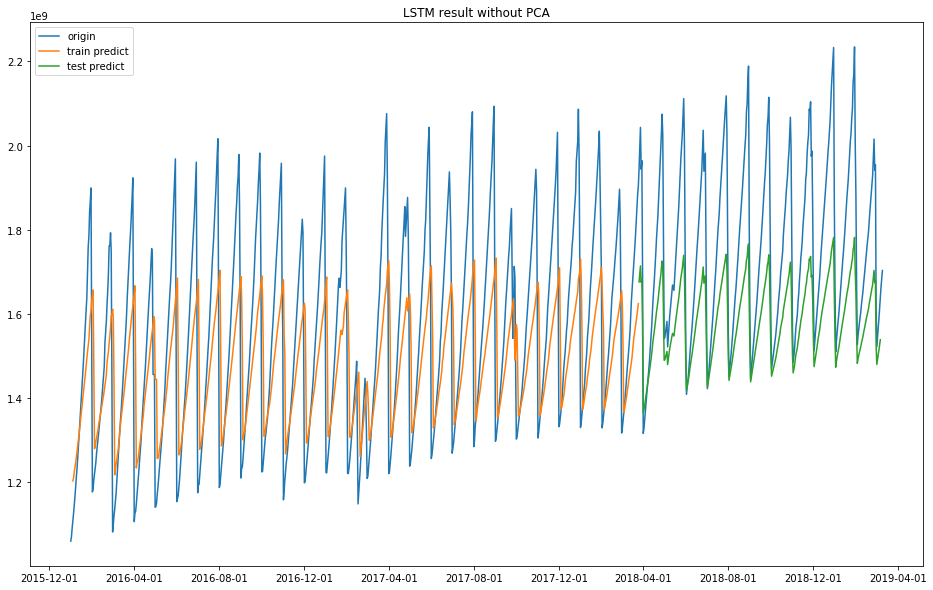

In [26]:
trainPredictPlot = np.empty_like(train_dataset)
trainPredictPlot[:, :] = np.nan
# trainPredictPlot[steps:len(trainPredict)+steps, :] = trainPredict

testPredictPlot = np.empty_like(train_dataset)
testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(steps*2):len(train_dataset),:] = testPredict

plt.figure(figsize=(16,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('LSTM result without PCA')

plt.plot(train_dataset.iloc[:,0], label = 'origin')
plt.plot(train_dataset.iloc[3:815,1], label = 'train predict')
plt.plot(train_dataset.iloc[815:-3,1], label = 'test predict')

plt.legend()
plt.show()

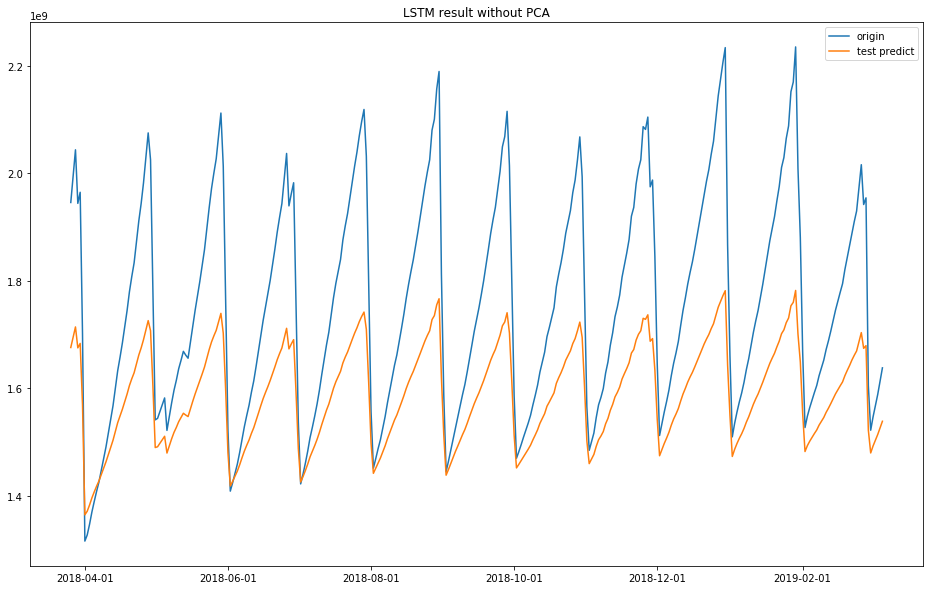

In [31]:
# testPredictPlot = np.empty_like(train_dataset[len(trainPredict)+(steps*2):len(train_dataset),:])
testPredictPlot[:, :] = np.nan

plt.figure(figsize=(16,10))
# plt.plot(train_dataset[len(trainPredict)+(steps*2):len(train_dataset),:], label = 'origin')
# plt.plot(testPredict, label = 'test predict', color='green')

plt.title('LSTM result without PCA')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(train_dataset.iloc[815:-3,0], label = 'origin')
plt.plot(train_dataset.iloc[815:-3,1], label = 'test predict')

plt.legend()
plt.show()

In [27]:
dataset['evaluation'] = 0
dataset.head(3)

,Unnamed: 0,origin_total,total,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,...,Comp.10,Comp.11,Comp.12,Comp.13,Comp.14,Comp.15,Comp.16,Comp.17,Comp.18,evaluation
stat_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,1.054359e+09,1.060150e+09,-3.722967,3.995390,-1.427039,-0.342712,0.250247,1.122027,0.187155,...,2.537875,-0.090666,-0.115397,-0.085228,0.078117,0.238693,0.359661,-0.213082,-0.017273,0
2016-01-02,2,1.066313e+09,1.070989e+09,-3.977367,3.852914,-1.388795,-0.385318,0.282414,1.105422,0.255038,...,2.252362,0.018632,-0.507548,-0.359579,0.164461,0.175537,0.172459,-0.205090,-0.049985,0
2016-01-03,3,1.092257e+09,1.091527e+09,-3.834691,2.950487,-2.036668,-0.270303,0.362256,1.271677,-0.045781,...,1.494543,0.392993,-0.250873,0.524982,0.683681,0.021026,0.251070,-0.336074,0.098757,0


In [28]:
trainPredict_flatten = trainPredict.flatten()
testPredict_flatten = testPredict.flatten()

In [29]:
eva_train = []
sum_train = 0
len_train = 0
for i in range(len(trainPredict)):
    evaluation_train = abs((trainPredict[i]/trainY[0][i])-1)
    eva_train.append(evaluation_train)
    sum_train += evaluation_train
    len_train += 1
print('result: ' + str(sum_train / len_train))

result: 0.09414151049801268


In [30]:
eva_test = []
sum_test = 0
len_test = 0
for i in range(len(testPredict)):
    evaluation_test = abs((testPredict[i]/testY[0][i])-1)
    eva_test.append(evaluation_test)
    sum_test += evaluation_test
    len_test += 1
print('result: ' + str(sum_test / len_test))

result: 0.11123689608050913


In [ ]:
submission_time = pd.DataFrame({
    'time': dataset.stat_date
})

submission_train = pd.DataFrame({
    'train_origin': reduce(operator.add, trainY),
    'train_Predict': trainPredict_flatten,
    'train_evaluation': eva_train
})

submission_test = pd.DataFrame({
    'test_origin': reduce(operator.add, testY),
    'test_predict': testPredict_flatten,
    'test_evaluation': eva_test
})

submission_avg_train = pd.DataFrame({
    'train_evlu_avg': (sum_train / len_train)
})

submission_avg_test = pd.DataFrame({
    'test_evlu_avg': (sum_test / len_test)
})
result = pd.concat([submission_train,submission_avg_train, submission_test, submission_avg_test], axis=1)
result.to_csv('/home/yaoling/Desktop/hangyan/result.csv', index=True)